In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os

dir_list = os.listdir('Primary Care Calibration\\Manually Validated Participants')
calList = pandas.read_excel('Primary Care Calibration\\Manually Validated Participants\\Calibration List.xlsx').to_numpy()

inds = np.zeros(len(dir_list)-1)
for i in range(len(dir_list)-1):
    if calList[i, 1]=='Good':
        inds[i] = 1

In [2]:
def dataClean(data, reg=np.array([[0, 1920], [0, 1080]])):
    for l in range(len(data[:, 0])):
        if data[l, 4]<reg[0, 0] or data[l, 4]>reg[0, 1] or data[l, 5]<reg[1, 0] or data[l, 5]>reg[1, 1]:
            data[l, 3] = 0

    validData = np.zeros(shape=(int(sum(data[:, 3])), 6))

    j = 0
    for k in range(len(data[:, 0])):
        if data[k, 3] == 1:
            validData[j, :] = data[k, :]
            j= j + 1
    return validData

In [3]:
sm = np.array([[0, 550], [200, 600]])
speedom = np.array([[820, 1000], [200, 400]])
rv = np.array([[1250, 1900], [540, 800]])
road = np.array([[600, 1050], [400, 550]])
panel = np.array([[1240, 1640], [0, 270]])

def regConv(region, comAvgs, comSDs):
    newReg = region - (np.ones(2)[None].T @ comAvgs[None]).T + 2*(np.array([-1, 1])[None].T @ comSDs[None]).T
    return newReg

comAvgs = np.array([997.388, 466.393])
comSDs = np.array([28.058, 29.206])

newSm = regConv(sm, comAvgs, comSDs)
newSpeedom = regConv(speedom, comAvgs, comSDs)
newRv = regConv(rv, comAvgs, comSDs)
newRoad = regConv(road, comAvgs, comSDs)
newPanel = regConv(panel, comAvgs, comSDs)


In [4]:
def regComs(data):
    validData = dataClean(data)

    n = len(validData[:, 4])

    avgs = ((validData[:, 4:].T  @ np.ones(n)[None].T)/n).T[0]

    dispMatr = np.ones(len(validData[:, 0]))[None].T @ avgs[None]
    validData[:, 4:] = validData[:, 4:] - dispMatr

    smData = dataClean(validData, newSm)
    validData[:, 3] = np.ones(n)
    speedomData = dataClean(validData, newSpeedom)
    validData[:, 3] = np.ones(n)
    rvData = dataClean(validData, newRv)
    validData[:, 3] = np.ones(n)
    roadData = dataClean(validData, newRoad)
    validData[:, 3] = np.ones(n)
    panelData = dataClean(validData, newPanel)

    m = len(smData[:, 4])
    smAvgs = ((smData[:, 4:].T  @ np.ones(m)[None].T)/m).T[0]
    m = len(speedomData[:, 4])
    speedomAvgs = ((speedomData[:, 4:].T  @ np.ones(m)[None].T)/m).T[0]
    m = len(rvData[:, 4])
    rvAvgs = ((rvData[:, 4:].T  @ np.ones(m)[None].T)/m).T[0]
    m = len(roadData[:, 4])
    roadAvgs = ((roadData[:, 4:].T  @ np.ones(m)[None].T)/m).T[0]
    m = len(panelData[:, 4])
    panelAvgs = ((panelData[:, 4:].T  @ np.ones(m)[None].T)/m).T[0]
    
    return avgs, smAvgs, speedomAvgs, rvAvgs, roadAvgs, panelAvgs

[[34.25642392 21.95453001]
 [15.23754733 15.13710234]
 [29.31201754 16.78361926]
 [12.90655847  6.62244055]
 [19.07620144 18.06992665]]
[[-631.20976133  -29.62292165]
 [ -62.35599362  -91.63778477]
 [ 436.96134437  110.11957783]
 [ -38.9361328    20.68282975]
 [ 434.2864718  -258.90634934]]


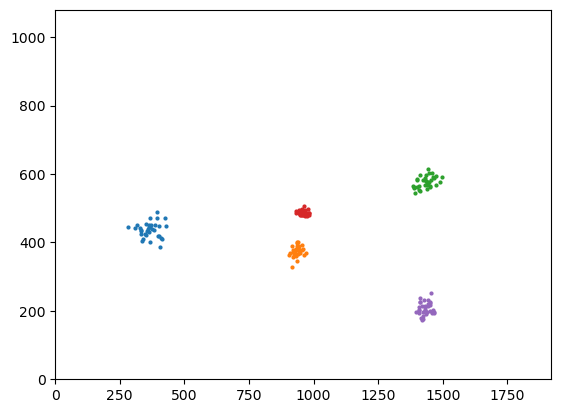

In [5]:
import statistics as stat
coms = np.zeros(shape=(6, 2, int(sum(inds))))

k=0
for i in range(len(dir_list)-1):
    if inds[i]==1:
        data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()
        coms[:, :, k] = regComs(data)
        k = k+1

varInfo = np.zeros(shape=(5, 2))
regAvgs = np.zeros(shape=(5, 2))
for j in range(5):
    dispMatr = np.ones(shape=(34))[None].T @ (coms[j+1, :, :] @ np.ones(shape=(34))[None].T/34).T
    regAvgs[j, :] = (coms[j+1, :, :] @ np.ones(shape=(34))[None].T/34)[:, 0]
    centered = coms[j+1, :, :] - dispMatr.T
    covar = centered @ centered.T/33
    varInfo[j, :] = np.sqrt(np.diag(covar))

for i in range(5):
    plt.plot(coms[i+1, 0, :] + comAvgs[0], coms[i+1, 1, :] + comAvgs[1], 'o', markersize=2)

print(varInfo)
print(regAvgs)

plt.xlim(0, 1920); plt.ylim(0, 1080)
plt.show()

In [6]:
from sko.PSO import PSO
import random
import sys

def linfFunc(p, data):
    n = len(data[:, 0])
    dispMatr = np.ones(shape=(n))[None].T @ p[None]
    newData = data-dispMatr
    inds = np.where(np.logical_and(abs(newData[:, 0])<100, abs(newData[:, 1])<100))[0]
    l = len(inds)
    if l==0:
        return 99999999
    else:
        sum = 0
        for i in range(l):
            sum = sum + max(abs(newData[inds[i], :]))
        return sum/l**2

def psoRun(reg, iter, psoFunc):
    seed = random.randrange(0, sys.maxsize); random.seed(seed)
    pso = PSO(func=psoFunc, n_dim=2, pop=40, max_iter=iter, lb=reg[:, 0], ub=reg[:, 1], w=0.7, c1=0.5, c2=0.5) # performs PSO fitting over omegas
    pso.run()
    return pso.gbest_x

def regPso(data, distFunc):
    validData = dataClean(data)

    n = len(validData[:, 4])

    avgs = ((validData[:, 4:].T  @ np.ones(n)[None].T)/n).T[0]

    dispMatr = np.ones(len(validData[:, 0]))[None].T @ avgs[None]
    validData[:, 4:] = validData[:, 4:] - dispMatr

    psoFunc = lambda p: distFunc(p, validData[:, 4:])
    smPso = psoRun(newSm, 30, psoFunc)
    speedomPso = psoRun(newSpeedom, 30, psoFunc)
    rvPso = psoRun(newRv, 30, psoFunc)
    roadPso = psoRun(newRoad, 30, psoFunc)
    panelPso = psoRun(newPanel, 30, psoFunc)

    return smPso, speedomPso, rvPso, roadPso, panelPso

In [7]:
psoCenters = np.zeros(shape=(5, 2, int(sum(inds))))

k=0
for i in range(len(dir_list)-1):
    if inds[i]==1:
        data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()
        psoCenters[:, :, k] = regPso(data, linfFunc)
        k = k+1

[[ 87.77164781  34.27963021]
 [ 18.11359118   0.        ]
 [  0.           9.12466392]
 [ 18.21341498  10.05894097]
 [147.19473751  75.76598271]]


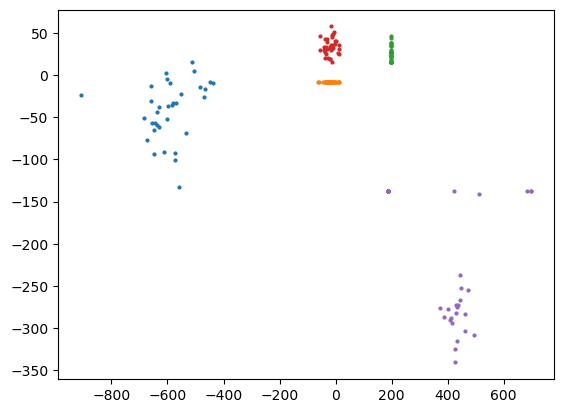

In [9]:
varInfo = np.zeros(shape=(5, 2))
for j in range(5):
    dispMatr = np.ones(shape=(34))[None].T @ (psoCenters[j, :, :] @ np.ones(shape=(34))[None].T/34).T
    centered = psoCenters[j, :, :] - dispMatr.T
    covar = centered @ centered.T/33
    varInfo[j, :] = np.sqrt(np.diag(covar))

for i in range(5):
    plt.plot(psoCenters[i, 0, :], psoCenters[i, 1, :], 'o', markersize=2)

print(varInfo)
plt.show()

In [ ]:
def boxCircFunc(p, data):
    n = len(data[:, 0])
    dispMatr = np.ones(shape=(n))[None].T @ p[None]
    newData = data-dispMatr
    inds = np.where(np.logical_and(abs(newData[:, 0])<100, abs(newData[:, 1])<100))[0]
    l = len(inds)
    if l==0:
        return 99999999
    else:
        sum = 0
        p = 0
        for i in range(l):
            r2 = newData[inds[i], :] @ newData[inds[i], :]
            if r2 < 10000:
                sum = sum + r2
                p = p + 1
        if p == 0:
            return 99999999
        else:
            return sum/p**2

psoL2Centers = np.zeros(shape=(5, 2, int(sum(inds))))

k=0
for i in range(len(dir_list)-1):
    if inds[i]==1:
        data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()
        psoL2Centers[:, :, k] = regPso(data, boxCircFunc)
        k = k+1

[[ 89.82498388  43.58909471]
 [ 24.36896495  29.1275682 ]
 [ 27.60052015  29.44301625]
 [ 23.58590392  32.82831493]
 [165.56522938  75.85719336]]


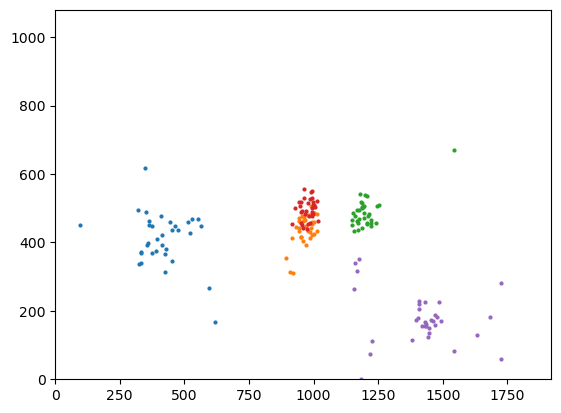

In [ ]:
varInfo = np.zeros(shape=(5, 2))
for j in range(5):
    dispMatr = np.ones(shape=(34))[None].T @ (psoCenters[j, :, :] @ np.ones(shape=(34))[None].T/34).T
    centered = psoCenters[j, :, :] - dispMatr.T
    covar = centered @ centered.T/33
    varInfo[j, :] = np.sqrt(np.diag(covar))

for i in range(5):
    plt.plot(psoL2Centers[i, 0, :], psoL2Centers[i, 1, :], 'o', markersize=2)

print(varInfo)
plt.xlim(0, 1920); plt.ylim(0, 1080)
plt.show()

In [ ]:
def l0Func(p, data):
    n = len(data[:, 0])
    dispMatr = np.ones(shape=(n))[None].T @ p[None]
    newData = data-dispMatr
    inds = np.where(np.logical_and(abs(newData[:, 0])<100, abs(newData[:, 1])<100))[0]
    l = len(inds)
    if l==0:
        return 99999999
    else:
        sum = 0
        p = 0
        for i in range(l):
            r0 = abs(newData[inds[i], :]) @ np.ones(2)
            if r0 < 100:
                sum = sum + r0
                p = p + 1
        if p==0:
            return 99999999
        return sum/p**2

psoL0Centers = np.zeros(shape=(5, 2, int(sum(inds))))

k=0
for i in range(len(dir_list)-1):
    if inds[i]==1:
        data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()
        psoL0Centers[:, :, k] = regPso(data, boxCircFunc)
        k = k+1

[[ 89.82498388  43.58909471]
 [ 24.36896495  29.1275682 ]
 [ 27.60052015  29.44301625]
 [ 23.58590392  32.82831493]
 [165.56522938  75.85719336]]


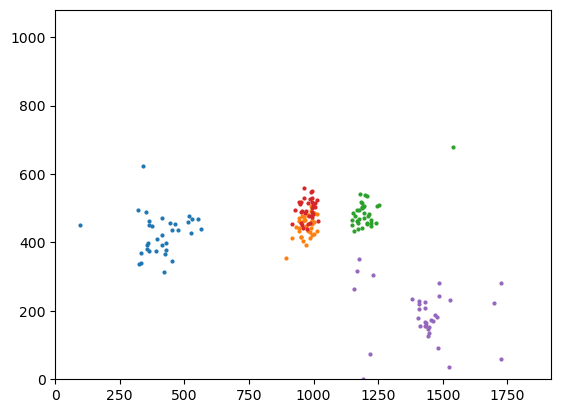

In [ ]:
varInfo = np.zeros(shape=(5, 2))
for j in range(5):
    dispMatr = np.ones(shape=(34))[None].T @ (psoCenters[j, :, :] @ np.ones(shape=(34))[None].T/34).T
    centered = psoCenters[j, :, :] - dispMatr.T
    covar = centered @ centered.T/33
    varInfo[j, :] = np.sqrt(np.diag(covar))

for i in range(5):
    plt.plot(psoL0Centers[i, 0, :], psoL0Centers[i, 1, :], 'o', markersize=2)

print(varInfo)
plt.xlim(0, 1920); plt.ylim(0, 1080)
plt.show()